# Myofibroblasts

In [8]:
import scanpy as sc
from tidyverse.dummy import *
from sctools.scplotting import recolor
import gc
import pertpy as pt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
from sctools.composition import compositional_pca, plot_pca_loadings
plt.rcParams["figure.figsize"] = (4,3)

from prop_utils import annotate_qval_to_scCODA_result, renamer

import sys
sys.path.append('..')
from util import load_celltype
from colormaps import color_dict_diagnosis, cmap_subtypes
from matplotlib.colors import ListedColormap

/tmp/ipykernel_149855/4059287409.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [9]:
plotfolder = '/tmp/proportions/MyoFibroblast_proportions/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

# SCCODA

In [10]:
A = load_celltype('Myofibroblasts')
A.obs.diagnosis = pd.Categorical(A.obs.diagnosis)
recolor(A, 'diagnosis', color_dict_diagnosis)

In [11]:
diagnosis_ordered = ['NE', 'M','D','T', 'NS']

In [12]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    A,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden",
    sample_identifier="samplename",
    covariate_obs=['samplename','diagnosis', 'procedure', 'patient'],
)
sccoda_data["coda"].obs['n_cells'] = sccoda_data["coda"].X.sum(1)
sccoda_data["coda"].obs['diagnosis'] = pd.Categorical(sccoda_data["coda"].obs['diagnosis'], diagnosis_ordered)

data_scanpy_1 = sccoda_data["coda"]

In [13]:
cluster_order = ['1','3','4','2','7','0','5','6']

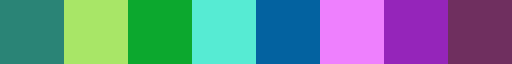

In [14]:
# reorder a little, to givve the pericytes a different hue
cmap_subtypes = np.array(cmap_subtypes.colors)[[1,2,3, 0, 7, 10,11,12]]
cmap_subtypes = ListedColormap(
    cmap_subtypes
)
cmap_subtypes

In [15]:
leiden_color_dict = dict(zip(cluster_order, cmap_subtypes.colors ))
_tmp = [leiden_color_dict[c] for c in A.obs.leiden.cat.categories]

if not 'leiden_colors_backup' in A.uns:
    A.uns['leiden_colors_backup']= A.uns['leiden_colors']
A.uns['leiden_colors'] = _tmp

In [16]:
set_matplotlib_formats('png')

/tmp/ipykernel_149855/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


/tmp/ipykernel_149855/2014126223.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


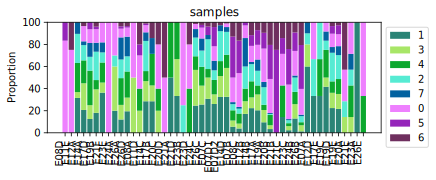

In [17]:
order = []
_snames = data_scanpy_1.obs.index.unique()
for d in diagnosis_ordered:
    order.extend(sorted(data_scanpy_1.obs.query('samplename in @_snames and diagnosis==@d').index))

set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="samples",
    figsize=(6,2), show=False, palette=cmap_subtypes,
    level_order=order
)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/Myofibroblasts_proportions_per_sample.svg')

## CODA-PCA

/tmp/ipykernel_149855/1696545352.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1719.87it/s]


<Axes: xlabel='leiden'>

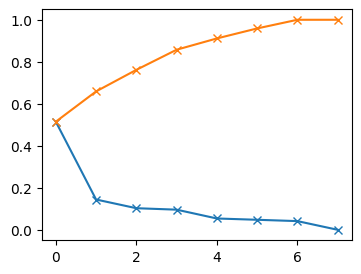

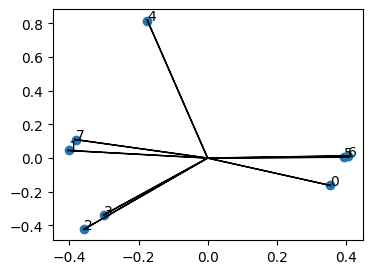

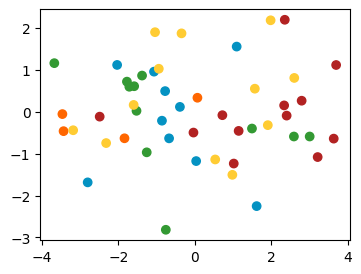

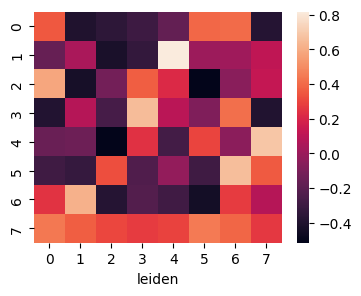

In [19]:
set_matplotlib_formats('png')
pca, scaler, x_pca_posterior, principal_components_df = compositional_pca(data_scanpy_1)
plt.plot(pca.explained_variance_ratio_, 'x-')
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'x-')

# plot_pca_with_uncertainty()
plt.figure()
plot_pca_loadings(principal_components_df)

plt.figure()
plt.scatter(x_pca_posterior[:,0], x_pca_posterior[:,1], c=[color_dict_diagnosis[_] for _ in data_scanpy_1.obs.diagnosis])

plt.figure()
sns.heatmap(principal_components_df)

## Barplots

In [20]:
set_matplotlib_formats('png')

/tmp/ipykernel_149855/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


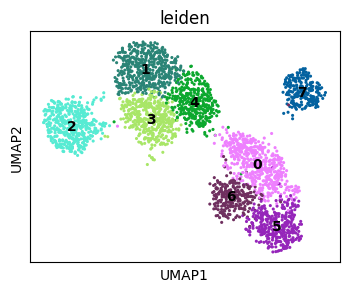

In [21]:
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20, show=False)
plt.savefig(f'{plotfolder}/Myofibroblasts_umap.svg')
plt.savefig(f'{plotfolder}/Myofibroblasts_umap.png')

In [22]:
## Fold change

In [23]:
a1 =  data_scanpy_1[data_scanpy_1.obs.diagnosis=='NE']
a2 =  data_scanpy_1[data_scanpy_1.obs.diagnosis=='T']
x1 = a1[:, ['0','5','6']].X.sum(1, keepdims=1)/ a1.X.sum(1, keepdims=True)
x2 = a2[:, ['0','5','6']].X.sum(1, keepdims=1)/ a2.X.sum(1, keepdims=True)

In [24]:
x1.mean(), x2.mean()

(0.3903542046973948, 0.6209559294530734)

/tmp/ipykernel_149855/2065238985.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


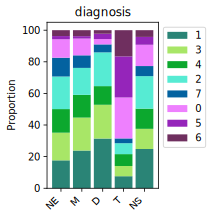

In [25]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="diagnosis",
    figsize=(2,3), show=False, palette=cmap_subtypes
)
fig.figure.savefig(f'{plotfolder}/Myofibroblast_proportions_per_diagnosis.svg')

In [26]:
set_matplotlib_formats('png')

/tmp/ipykernel_149855/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/MyoFibroblast_proportions//proportions_per_diagnosis_ncells.svg


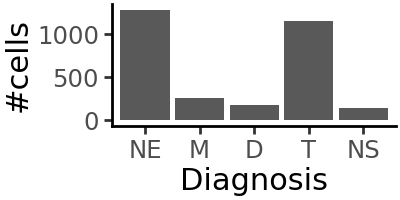

In [27]:
p = pn.ggplot(pd.DataFrame({'n_cells': data_scanpy_1.obs.groupby('diagnosis').n_cells.sum()}).reset_index(), pn.aes(x='diagnosis', y='n_cells')) + pn.geom_bar(stat='identity') \
+ pn.theme_classic() + pn.theme(figure_size=(2,1)) + pn.labs(x='Diagnosis', y='#cells')
p.save(f'{plotfolder}/proportions_per_diagnosis_ncells.svg')
p

In [28]:
q = pd.crosstab(
    pd.Series(pd.Categorical(A.obs.leiden, categories=cluster_order), name='leiden', index=A.obs.leiden.index),
    A.obs.diagnosis
)
norm_freqs = q.div( q.sum(1), axis=0)
norm_freqs = norm_freqs.unstack().reset_index().rename({0:'frequency'}, axis=1)
norm_freqs.diagnosis = pd.Categorical(norm_freqs.diagnosis, categories=diagnosis_ordered)

/tmp/ipykernel_3936196/1729294576.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/MyoFibroblast_proportions//Myofibroblast_proportions_per_cluster.svg


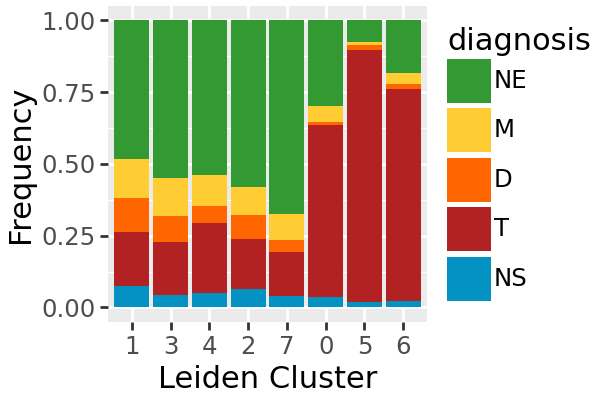

In [24]:
set_matplotlib_formats('svg')
p= pn.ggplot(
    norm_freqs,
    pn.aes(x='leiden', y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(3,2)) + pn.scale_fill_manual(color_dict_diagnosis)+ pn.labs(x='Leiden Cluster', y='Frequency')
p.save(f'{plotfolder}/Myofibroblast_proportions_per_cluster.svg')
p

In [25]:
set_matplotlib_formats('png')

/tmp/ipykernel_3936196/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


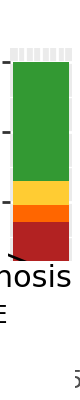

In [26]:
overall_props = A.obs.diagnosis.value_counts()
overall_props = overall_props/overall_props.sum()
overall_props = overall_props.loc[diagnosis_ordered]

_ddd = pd.DataFrame(overall_props).reset_index().rename({'count': 'frequency'}, axis=1)
_ddd.diagnosis = pd.Categorical(_ddd.diagnosis, categories=diagnosis_ordered)

pn.ggplot(
    _ddd,
    pn.aes(x=1, y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(7,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.theme(figure_size=(0.4,2)) + pn.labs(x='', y='Frequency')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/MyoFibroblast_proportions//proportions_per_cluster_ncells.svg


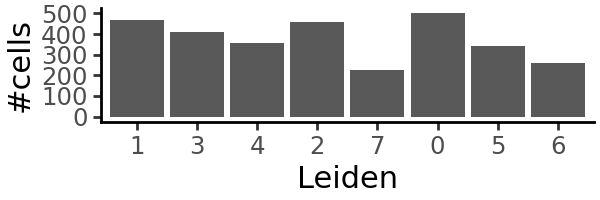

In [27]:
p = pn.ggplot(pd.DataFrame({'n_cells': q.reset_index().melt(id_vars=['leiden']).groupby('leiden').value.sum()}).reset_index(), pn.aes(x='leiden', y='n_cells')) + pn.geom_bar(stat='identity') \
 + pn.theme_classic() + pn.theme(figure_size=(3,1)) + pn.labs(x='Leiden', y='#cells')
p.save(f'{plotfolder}/proportions_per_cluster_ncells.svg')
p

## MCM

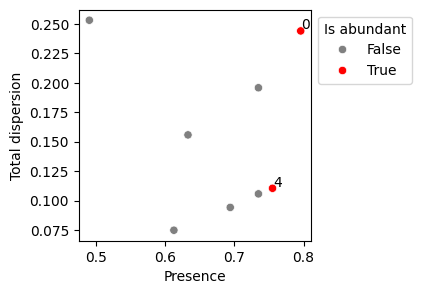

In [28]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, figsize=(3,3), abundant_threshold=0.75); plt.show()

In [37]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    # formula="TRG",
    formula="C(diagnosis, Treatment('NE')) + patient + procedure",
    reference_cell_type="4",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_data["coda"]

sample: 100%|███████████| 11000/11000 [11:54<00:00, 15.39it/s, 511 steps of size 8.99e-03. acc. prob=0.84]


AnnData object with n_obs × n_vars = 49 × 8
    obs: 'procedure', 'samplename', 'diagnosis', 'patient', 'n_cells'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', "effect_df_C(diagnosis, Treatment('NE'))[T.M]", "effect_df_C(diagnosis, Treatment('NE'))[T.D]", "effect_df_C(diagnosis, Treatment('NE'))[T.T]", "effect_df_C(diagnosis, Treatment('NE'))[T.NS]", 'effect_df_patient[T.E08]', 'effect_df_patient[T.E11]', 'effect_df_patient[T.E12]', 'effect_df_patient[T.E14]', 'effect_df_patient[T.E17]', 'effect_df_patient[T.E19]', 'effect_df_patient[T.E20]', 'effect_df_patient[T.E21]', 'effect_df_patient[T.E23]', 'effect_df_patient[T.E24]', 'effect_df_patient[T.E26]', 'effect_df_procedure[T.resection]'

In [42]:
sccoda_model.set_fdr(sccoda_data, est_fdr=0.05)
scCODA_result = sccoda_model.get_effect_df(sccoda_data)
scCODA_result['pvalue'] = 1-scCODA_result['Inclusion probability']
scCODA_result['log10pvalue'] = np.log10(scCODA_result['pvalue'])

scCODA_result = annotate_qval_to_scCODA_result(scCODA_result)

scCODA_result.to_csv(f'{plotfolder}/MCMC_diag_procedure_patient.csv')
scCODA_result[scCODA_result['Final Parameter'] != 0]

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


Final Parameter  HDI 3%  HDI 97%  \
Covariate                        Cell Type                                     
C(diagnosis, Treatment('NE'))T.T 0                 1.203174   0.799    1.549   
                                 5                 2.485760   1.973    2.980   
                                 6                 1.624888   1.132    2.090   
patientT.E12                     5                -1.299490  -2.415    0.005   
patientT.E14                     5                -0.928095  -1.690   -0.129   
patientT.E17                     0                -1.771424  -2.497   -0.975   
                                 5                -1.670519  -2.452   -0.861   
                                 6                -1.803322  -2.695   -0.871   
patientT.E24                     3                 0.590207  -0.043    1.162   
patientT.E26                     1                -0.527056  -0.960    0.007   
procedureT.resection             0                -1.187434  -1.720   -0.610   
                                 1                 0.724976  -0.005    1.255   
                                 5                -0.843454  -1.406   -0.257   
                                 6                -1.253565  -1.815   -0.581   

                                               SD  Inclusion probability  \
Covariate                        Cell Type                                 
C(diagnosis, Treatment('NE'))T.T 0          0.191                 1.0000   
                                 5          0.261                 1.0000   
                                 6          0.244                 1.0000   
patientT.E12                     5          0.723                 0.9250   
patientT.E14                     5          0.446                 0.9599   
patientT.E17                     0          0.387                 1.0000   
                                 5          0.409                 0.9999   
                                 6          0.470                 1.0000   
patientT.E24                     3          0.382                 0.8501   
patientT.E26                     1          0.302                 0.8764   
procedureT.resection             0          0.292                 0.9985   
                                 1          0.398                 0.8418   
                                 5          0.335                 0.9594   
                                 6          0.321                 0.9994   

                                            Expected Sample  log2-fold change  \
Covariate                        Cell Type                                      
C(diagnosis, Treatment('NE'))T.T 0                19.849584          0.179623   
                                 5                18.930398          2.030003   
                                 6                12.908647          0.788028   
patientT.E12                     5                 1.335280         -1.795488   
patientT.E14                     5                 1.917564         -1.273356   
patientT.E17                     0                 4.882074         -1.843920   
                                 5                 1.428286         -1.698345   
                                 6                 2.017123         -1.889939   
patientT.E24                     3                12.633125          0.716506   
patientT.E26                     1                 4.238527         -0.694603   
procedureT.resection             0                 6.714998         -1.384027   
                                 1                17.792091          1.374998   
                                 5                 2.505087         -0.887769   
                                 6                 2.681060         -1.479434   

                                            pvalue  log10pvalue  \
Covariate                        Cell Type                        
C(diagnosis, Treatment('NE'))T.T 0          0.0000         -inf   
                                 5          0.00

In [43]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})

/tmp/ipykernel_3936196/972804642.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


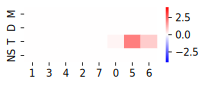

In [44]:
set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(3, 1))
sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
# plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)
fig.savefig(f'{plotfolder}/matrix_scCODA.svg')

In [45]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change'], aggfunc=np.mean).replace({np.nan: 0})
a

Cell Type,0,1,2,3,4,5,6,7
Covariate,,,,,,,,
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T,0.179623,-1.556191,-1.556191,-1.556191,-1.556191,2.030003,0.788028,-1.556191
patientT.E08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E12,0.079279,0.079279,0.079279,0.079279,0.079279,-1.795488,0.079279,0.079279
patientT.E14,0.065603,0.065603,0.065603,0.065603,0.065603,-1.273356,0.065603,0.065603
patientT.E17,-1.843920,0.711704,0.711704,0.711704,0.711704,-1.698345,-1.889939,0.711704


/tmp/ipykernel_3936196/3154158120.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


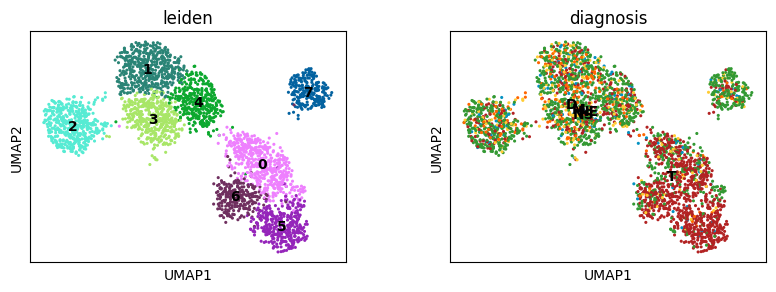

In [46]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden', 'diagnosis'], legend_loc='on data', size=20)

# Marker

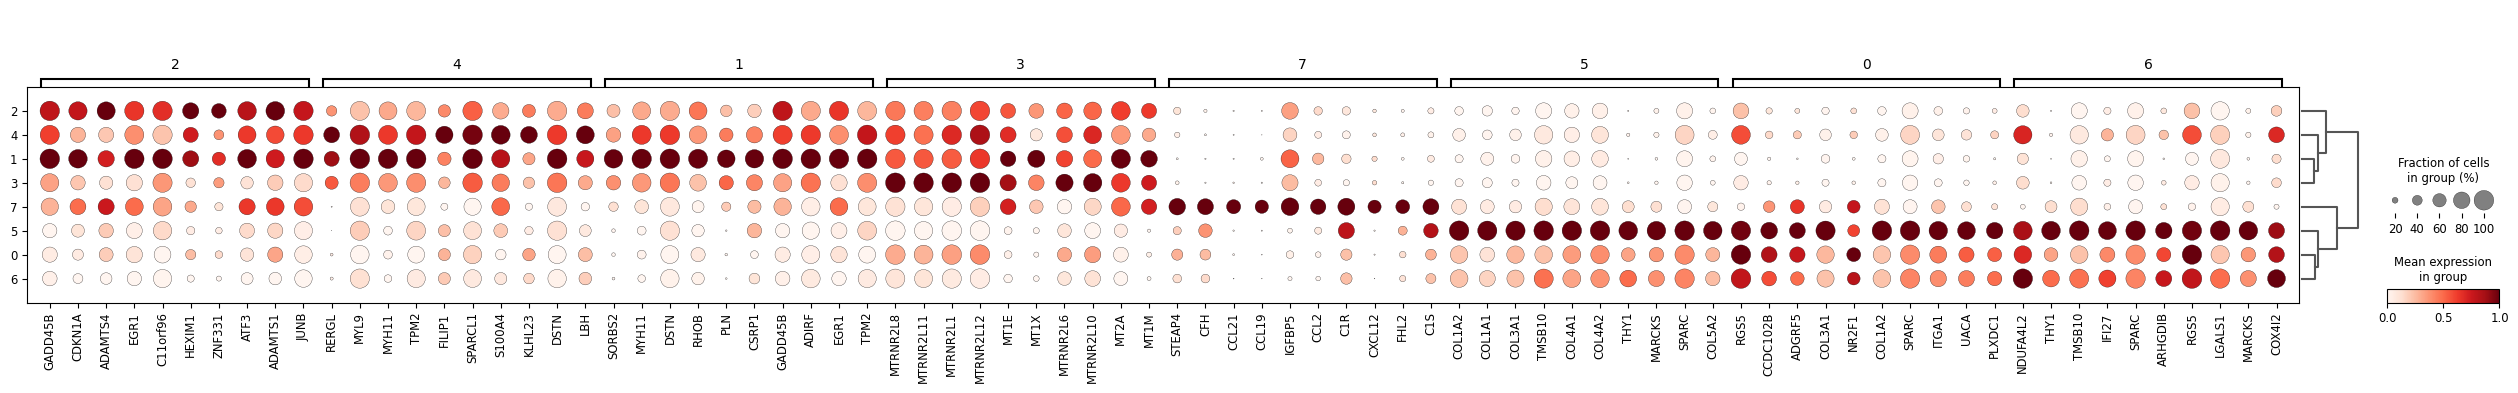

In [47]:
sc.tl.dendrogram(A, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var')

/tmp/ipykernel_3936196/191252745.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


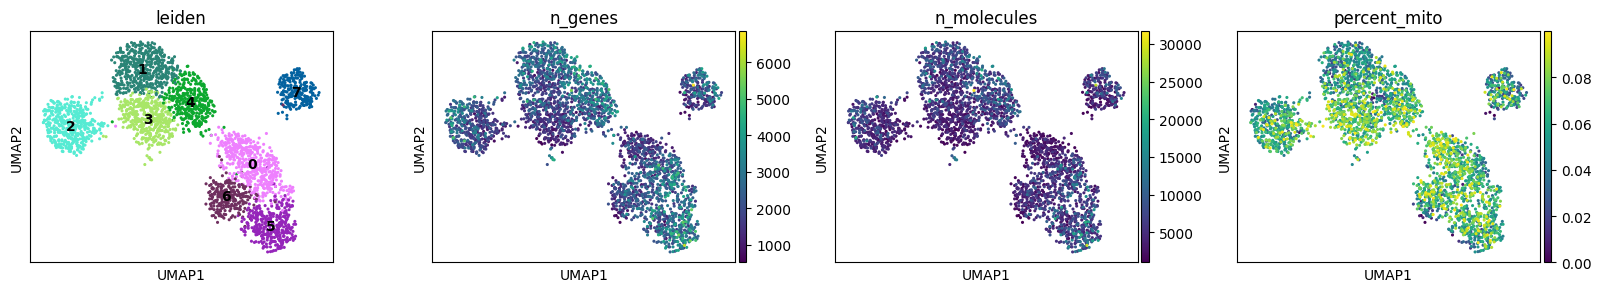

In [48]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden', 'n_genes','n_molecules', 'percent_mito'], legend_loc='on data', size=20)

/tmp/ipykernel_149855/347886629.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


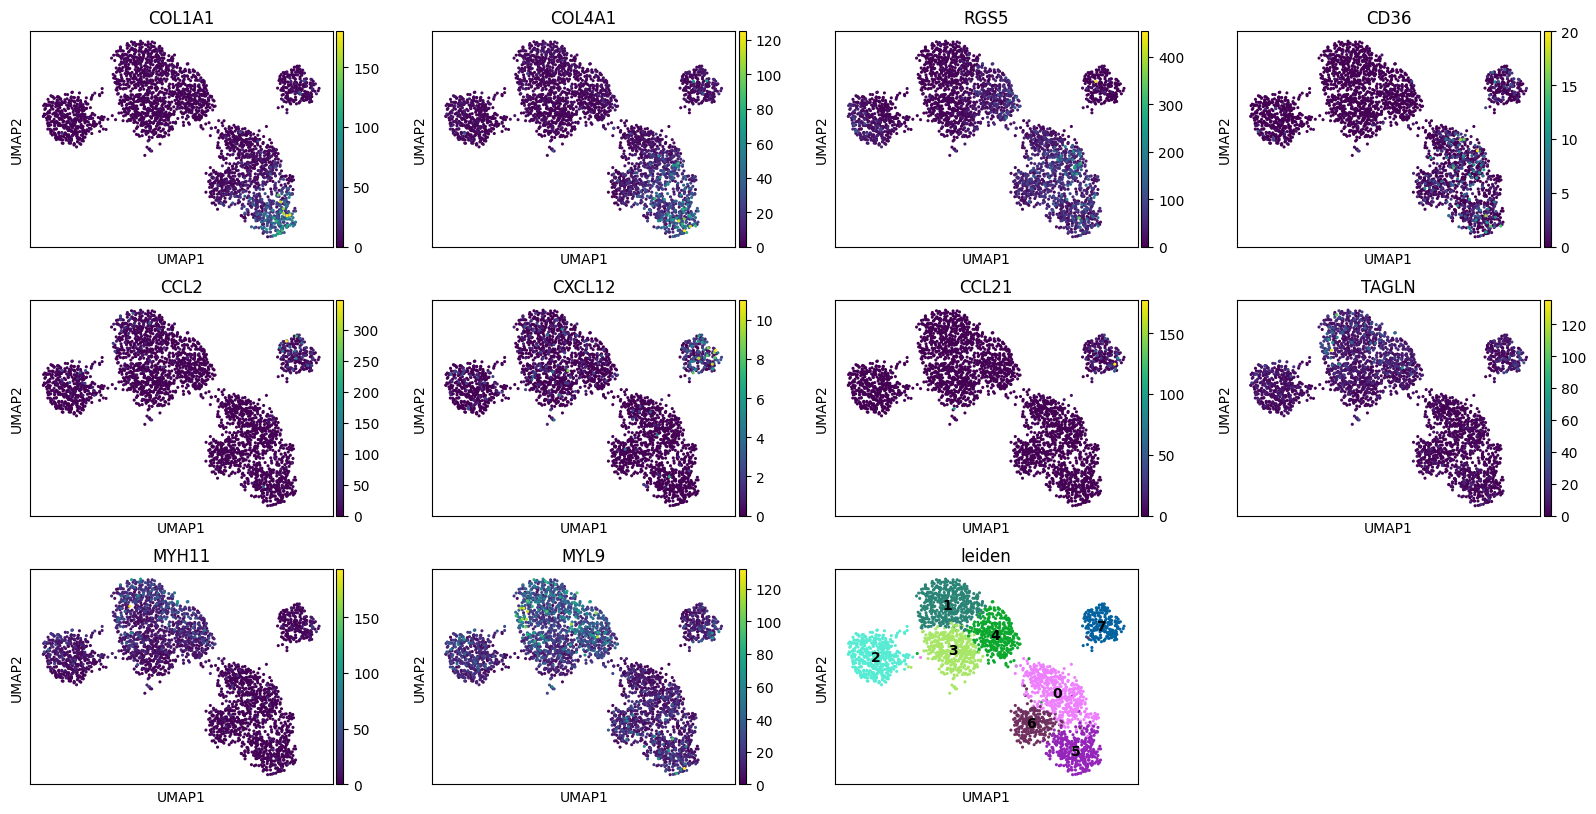

/tmp/ipykernel_149855/347886629.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


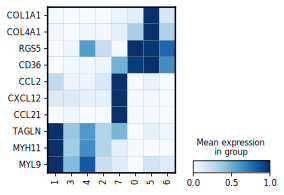

In [30]:
genes =['COL1A1', 'COL4A1', 'RGS5', 'CD36',
        'CCL2', 'CXCL12','CCL21',
       'TAGLN', 'MYH11', 'MYL9']
set_matplotlib_formats('png')
sc.pl.umap(A, color=genes+['leiden'], legend_loc='on data', size=20)

B = A.copy()
B.obs['leiden'] = pd.Categorical(B.obs['leiden'], categories=cluster_order)
set_matplotlib_formats('svg')

sc.pl.matrixplot(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, show=False, #order=cluster_order
                figsize=(4,3), cmap='Blues')
plt.savefig(f'{plotfolder}/MyoF_markers_matrix.svg')